In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [3]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"] # "Product_Category_B", "Region"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [4]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    #data = data.drop_duplicates([x for x in data.columns if x != 'ID'])
    
    return (data)

In [5]:
import catboost as ctb

In [6]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [7]:
rest = [x for x in data.columns if x != 'ID']
len(data[data.duplicated(rest)])/float(len(data)) * 100

2.643535729037588

In [8]:
prep = preprocess(data)

In [9]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [10]:
len(prep[prep.duplicated()])

481

In [11]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [12]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [13]:
cat_vars

['Region',
 'Territory',
 'Bureaucratic_Code',
 'Source',
 'Billing_Country',
 'Account_Owner',
 'Opportunity_Owner',
 'Currency',
 'Last_Modified_By',
 'Delivery_Quarter']

In [14]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [15]:
cat_indexes

[0, 1, 6, 7, 8, 9, 10, 11, 12, 15]

In [79]:
grid = {
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [100, 150, 200, 500, 1000]
}

In [80]:
model = ctb.CatBoostClassifier(max_bin=400,
                               num_leaves=31,
                               rsm=0.98,
                               eval_metric='Logloss',
                               use_best_model=True,
                               random_seed=42)

In [81]:
grid = RandomizedSearchCV(model, grid, verbose=1, cv=5, n_jobs=-1, n_iter=50)

In [82]:
rdmres = grid.fit(X=prep.drop(target, axis=1), y=prep.Stage, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 38.7min finished


0:	learn: 0.2130344	test: 0.2172542	best: 0.2172542 (0)	total: 21.7ms	remaining: 10.8s
1:	learn: 0.1325442	test: 0.1376220	best: 0.1376220 (1)	total: 44.6ms	remaining: 11.1s
2:	learn: 0.1143017	test: 0.1202497	best: 0.1202497 (2)	total: 69.5ms	remaining: 11.5s
3:	learn: 0.1037859	test: 0.1080403	best: 0.1080403 (3)	total: 90.7ms	remaining: 11.2s
4:	learn: 0.0978888	test: 0.1013483	best: 0.1013483 (4)	total: 111ms	remaining: 10.9s
5:	learn: 0.0933928	test: 0.0961789	best: 0.0961789 (5)	total: 132ms	remaining: 10.9s
6:	learn: 0.0882303	test: 0.0903365	best: 0.0903365 (6)	total: 153ms	remaining: 10.7s
7:	learn: 0.0824523	test: 0.0832061	best: 0.0832061 (7)	total: 181ms	remaining: 11.1s
8:	learn: 0.0799880	test: 0.0804383	best: 0.0804383 (8)	total: 202ms	remaining: 11s
9:	learn: 0.0767893	test: 0.0765449	best: 0.0765449 (9)	total: 222ms	remaining: 10.9s
10:	learn: 0.0719721	test: 0.0722655	best: 0.0722655 (10)	total: 249ms	remaining: 11.1s
11:	learn: 0.0719719	test: 0.0722655	best: 0.07226

104:	learn: 0.0205632	test: 0.0272440	best: 0.0272440 (104)	total: 2.15s	remaining: 8.09s
105:	learn: 0.0205631	test: 0.0272438	best: 0.0272438 (105)	total: 2.17s	remaining: 8.08s
106:	learn: 0.0205629	test: 0.0272428	best: 0.0272428 (106)	total: 2.19s	remaining: 8.06s
107:	learn: 0.0205629	test: 0.0272428	best: 0.0272428 (106)	total: 2.21s	remaining: 8.03s
108:	learn: 0.0204720	test: 0.0270644	best: 0.0270644 (108)	total: 2.23s	remaining: 8.01s
109:	learn: 0.0199769	test: 0.0268895	best: 0.0268895 (109)	total: 2.25s	remaining: 7.99s
110:	learn: 0.0199766	test: 0.0268892	best: 0.0268892 (110)	total: 2.27s	remaining: 7.96s
111:	learn: 0.0199763	test: 0.0268877	best: 0.0268877 (111)	total: 2.29s	remaining: 7.92s
112:	learn: 0.0197897	test: 0.0267903	best: 0.0267903 (112)	total: 2.31s	remaining: 7.91s
113:	learn: 0.0197897	test: 0.0267898	best: 0.0267898 (113)	total: 2.33s	remaining: 7.88s
114:	learn: 0.0197872	test: 0.0267886	best: 0.0267886 (114)	total: 2.35s	remaining: 7.87s
115:	learn

196:	learn: 0.0118991	test: 0.0190621	best: 0.0190621 (196)	total: 4.01s	remaining: 6.16s
197:	learn: 0.0115609	test: 0.0185516	best: 0.0185516 (197)	total: 4.03s	remaining: 6.15s
198:	learn: 0.0114574	test: 0.0184892	best: 0.0184892 (198)	total: 4.05s	remaining: 6.12s
199:	learn: 0.0113736	test: 0.0184050	best: 0.0184050 (199)	total: 4.07s	remaining: 6.1s
200:	learn: 0.0113736	test: 0.0184049	best: 0.0184049 (200)	total: 4.08s	remaining: 6.07s
201:	learn: 0.0113736	test: 0.0184049	best: 0.0184049 (201)	total: 4.1s	remaining: 6.05s
202:	learn: 0.0113736	test: 0.0184050	best: 0.0184049 (201)	total: 4.12s	remaining: 6.02s
203:	learn: 0.0113735	test: 0.0184051	best: 0.0184049 (201)	total: 4.13s	remaining: 6s
204:	learn: 0.0113735	test: 0.0184051	best: 0.0184049 (201)	total: 4.15s	remaining: 5.97s
205:	learn: 0.0113735	test: 0.0184051	best: 0.0184049 (201)	total: 4.17s	remaining: 5.95s
206:	learn: 0.0113735	test: 0.0184050	best: 0.0184049 (201)	total: 4.18s	remaining: 5.92s
207:	learn: 0.0

288:	learn: 0.0096701	test: 0.0168257	best: 0.0168211 (279)	total: 5.67s	remaining: 4.14s
289:	learn: 0.0096701	test: 0.0168255	best: 0.0168211 (279)	total: 5.69s	remaining: 4.12s
290:	learn: 0.0095751	test: 0.0168077	best: 0.0168077 (290)	total: 5.71s	remaining: 4.1s
291:	learn: 0.0095751	test: 0.0168076	best: 0.0168076 (291)	total: 5.73s	remaining: 4.08s
292:	learn: 0.0095751	test: 0.0168076	best: 0.0168076 (291)	total: 5.75s	remaining: 4.06s
293:	learn: 0.0095751	test: 0.0168078	best: 0.0168076 (291)	total: 5.76s	remaining: 4.04s
294:	learn: 0.0095750	test: 0.0168078	best: 0.0168076 (291)	total: 5.78s	remaining: 4.02s
295:	learn: 0.0095750	test: 0.0168078	best: 0.0168076 (291)	total: 5.8s	remaining: 4s
296:	learn: 0.0095749	test: 0.0168079	best: 0.0168076 (291)	total: 5.82s	remaining: 3.98s
297:	learn: 0.0094548	test: 0.0165320	best: 0.0165320 (297)	total: 5.84s	remaining: 3.96s
298:	learn: 0.0094546	test: 0.0165314	best: 0.0165314 (298)	total: 5.86s	remaining: 3.94s
299:	learn: 0.0

382:	learn: 0.0083679	test: 0.0158087	best: 0.0157905 (377)	total: 7.38s	remaining: 2.25s
383:	learn: 0.0083679	test: 0.0158086	best: 0.0157905 (377)	total: 7.4s	remaining: 2.23s
384:	learn: 0.0082396	test: 0.0158468	best: 0.0157905 (377)	total: 7.42s	remaining: 2.22s
385:	learn: 0.0082396	test: 0.0158468	best: 0.0157905 (377)	total: 7.44s	remaining: 2.2s
386:	learn: 0.0081519	test: 0.0156053	best: 0.0156053 (386)	total: 7.46s	remaining: 2.18s
387:	learn: 0.0081501	test: 0.0156133	best: 0.0156053 (386)	total: 7.48s	remaining: 2.16s
388:	learn: 0.0080987	test: 0.0156430	best: 0.0156053 (386)	total: 7.5s	remaining: 2.14s
389:	learn: 0.0080986	test: 0.0156430	best: 0.0156053 (386)	total: 7.52s	remaining: 2.12s
390:	learn: 0.0080986	test: 0.0156431	best: 0.0156053 (386)	total: 7.54s	remaining: 2.1s
391:	learn: 0.0080100	test: 0.0154936	best: 0.0154936 (391)	total: 7.56s	remaining: 2.08s
392:	learn: 0.0080100	test: 0.0154933	best: 0.0154933 (392)	total: 7.58s	remaining: 2.06s
393:	learn: 0.

483:	learn: 0.0075595	test: 0.0149881	best: 0.0149861 (439)	total: 9.06s	remaining: 299ms
484:	learn: 0.0075595	test: 0.0149878	best: 0.0149861 (439)	total: 9.07s	remaining: 281ms
485:	learn: 0.0075594	test: 0.0149876	best: 0.0149861 (439)	total: 9.09s	remaining: 262ms
486:	learn: 0.0075591	test: 0.0149876	best: 0.0149861 (439)	total: 9.11s	remaining: 243ms
487:	learn: 0.0075591	test: 0.0149876	best: 0.0149861 (439)	total: 9.12s	remaining: 224ms
488:	learn: 0.0075591	test: 0.0149875	best: 0.0149861 (439)	total: 9.13s	remaining: 205ms
489:	learn: 0.0075590	test: 0.0149875	best: 0.0149861 (439)	total: 9.15s	remaining: 187ms
490:	learn: 0.0075590	test: 0.0149873	best: 0.0149861 (439)	total: 9.17s	remaining: 168ms
491:	learn: 0.0075586	test: 0.0149883	best: 0.0149861 (439)	total: 9.19s	remaining: 149ms
492:	learn: 0.0075586	test: 0.0149884	best: 0.0149861 (439)	total: 9.2s	remaining: 131ms
493:	learn: 0.0075586	test: 0.0149884	best: 0.0149861 (439)	total: 9.22s	remaining: 112ms
494:	learn:

In [83]:
trainedmodel = rdmres.best_estimator_

In [84]:
trainedmodel.get_all_params()

{u'auto_class_weights': u'None',
 u'bayesian_matrix_reg': 0.10000000149011612,
 u'best_model_min_trees': 1,
 u'boost_from_average': False,
 u'boosting_type': u'Plain',
 u'bootstrap_type': u'MVS',
 u'border_count': 400,
 u'class_names': [0, 1],
 u'classes_count': 0,
 u'combinations_ctr': [u'Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  u'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 u'counter_calc_method': u'SkipTest',
 u'ctr_leaf_count_limit': 18446744073709551615L,
 u'ctr_target_border_count': 1,
 u'depth': 8,
 u'eval_metric': u'Logloss',
 u'feature_border_type': u'GreedyLogSum',
 u'fold_permutation_block': 0,
 u'grow_policy': u'SymmetricTree',
 u'has_time': False,
 u'iterations': 500,
 u'l2_leaf_reg': 7,
 u'leaf_estimation_backtracking': u'AnyImprovement',
 u'leaf_estimation_iterations': 10,
 u'leaf_estimation_method': u'Newton',
 u'learning_rate': 0.5,
 u'loss_function': u'Logloss',

In [85]:
y_pred = trainedmodel.predict_proba(x_test.drop(target, axis=1))

In [86]:
res = y_pred[:,1]

In [87]:
for x in res[:10]:
    print("{:f}".format(x))

0.000025
0.000050
0.997531
0.999996
0.042656
0.992877
0.000429
0.000001
0.999661
0.001180


In [88]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [89]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

230

In [90]:
len(fuck)/float(len(res)) * 100

4.54096742349457

In [91]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [92]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [93]:
log_loss(answer["Stage"], answer["Prediction"])

0.017513429469016396

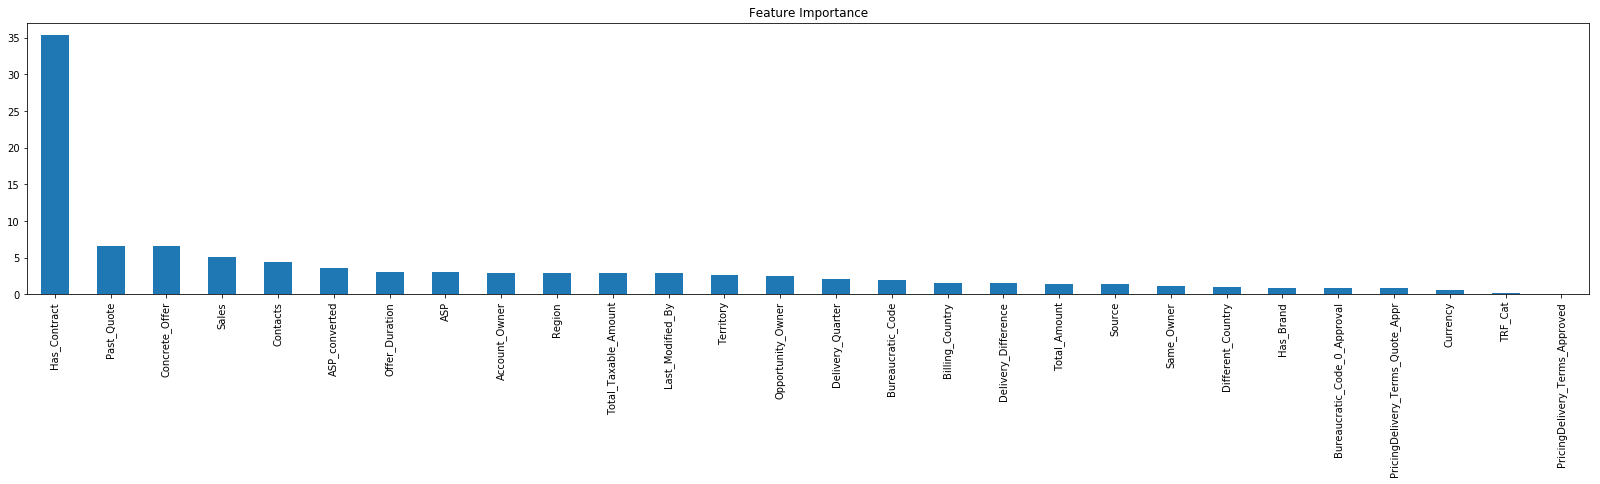

In [96]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(trainedmodel.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [97]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [98]:
bad

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Concrete_Offer,Offer_Duration,Territory_Defined,Past_Quote,Prediction
952,EMEA,Germany,1,0,0,0,Bureaucratic_Code_5,Source_7,Germany,511,1344,Person_Name_4,Person_Name_4,None,Person_Name_41,0.3875,0.43830,Q2,287525.00,287525.00,0,1,12.0,False,False,True,False,1.0,17,88.0,8.0,True,603.0,0.945039
10407,Americas,None,1,0,0,0,Bureaucratic_Code_5,Source_7,United States,6515,3390,Person_Name_33,Person_Name_33,None,Person_Name_47,0.4950,0.49500,Q1,285862.50,285862.50,0,1,30.0,False,False,True,False,1.0,73,89.0,NaN,False,NaN,0.604282
10629,EMEA,Hungary,0,0,0,0,Bureaucratic_Code_4,Source_3,Hungary,6613,3804,Person_Name_4,Person_Name_4,None,Person_Name_4,0.3750,0.42416,Q1,38671.88,38671.88,1,1,4.0,True,False,True,False,0.0,4,165.0,116.0,True,46.0,0.401915
7145,APAC,China (PRC),1,1,1,1,Bureaucratic_Code_4,None,China,4398,2178,Person_Name_65,Person_Name_19,None,Person_Name_47,0.2800,0.28000,Q2,103880.00,103880.00,0,1,15.0,False,False,True,True,0.0,215,32.0,46.0,True,223.0,0.891144
9399,Americas,Central US,0,0,0,0,Bureaucratic_Code_4,Source_13,United States,5930,2953,Person_Name_3,Person_Name_48,None,Person_Name_47,0.4250,0.42500,Q4,48386.25,48386.25,0,1,0.0,False,False,True,True,0.0,2,100.0,14.0,True,162.0,0.601696
1457,EMEA,Spain,1,1,0,0,Bureaucratic_Code_4,Source_11,Spain,833,1528,Person_Name_42,Person_Name_23,None,Person_Name_47,0.3750,0.42416,Q1,75937.50,75937.50,0,1,3.0,False,False,True,False,0.0,72,41.0,33.0,True,323.0,0.823686
8194,EMEA,Netherlands,0,0,0,0,Bureaucratic_Code_4,None,Netherlands,5126,2450,Person_Name_51,Person_Name_18,None,Person_Name_47,0.3750,0.42416,Q2,62109.38,62109.38,0,1,0.0,False,False,True,False,0.0,63,14.0,3.0,True,238.0,0.719162
12890,Americas,Central US,1,0,1,0,Bureaucratic_Code_5,None,United States,7819,4020,Person_Name_45,Person_Name_48,None,Person_Name_47,NaN,NaN,Q3,20000.00,668648.00,0,2,3.0,False,False,True,True,0.0,49,132.0,36.0,True,108.0,0.580892
1547,EMEA,Germany,1,1,1,1,Bureaucratic_Code_4,Source_9,Germany,897,1591,Person_Name_4,Person_Name_4,None,Person_Name_47,0.3900,0.44113,Q1,163995.00,163995.00,0,1,4.0,False,False,True,False,0.0,28,29.0,11.0,True,339.0,0.950773
13415,EMEA,Italy,1,0,0,0,Bureaucratic_Code_5,Source_11,Italy,8144,4306,Person_Name_2,Person_Name_2,None,Person_Name_2,0.3950,0.44678,Q2,88875.00,88875.00,0,1,4.0,True,False,True,False,0.0,55,32.0,19.0,True,17.0,0.647430


In [99]:
bad.Stage.value_counts()

0    17
1     1
Name: Stage, dtype: int64

In [101]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = trainedmodel.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [102]:
prev = pd.read_csv("acceptable/submission_23.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9928448096853774

In [103]:
prev = pd.read_csv("acceptable/submission_11.csv")
prev["Prediction"].corr(answer["Prediction"])

0.9868558367660449

In [37]:
#answer.to_csv("acceptable/submission_26.csv", header = False, index = False)

In [34]:
#p = prev.merge(answer, on = "Opportunity_ID")

In [35]:
#p["New_Prediction"] = (p.Prediction_x + p.Prediction_y) / 2.0

In [36]:
#pp = p[["Opportunity_ID", "New_Prediction"]]
#pp.to_csv("submission_24.csv", header = False, index = False)